## Data Generation

I used a particle gun of the following setting to generate this dataset.
The dataset is found in [google drive](https://drive.google.com/file/d/1BW3m7Gy41jBSJpba4oh--Y33wsqzbbvI/view?usp=sharing)

| particle name | momentum range [GeV] | theta ($\theta$) range [deg] | phi ($\phi$) range [deg] | No Of Events |
| --------------|----------------------|-------------------|-----------------|---------------|
| $\gamma$      |  0.1 - 4.0           |   1 - 11          |     0 - 360     | 500k |
| $\pi^{+}$     |  0.1 - 4.0           |   1 - 11          |     0 - 360     | 250k |
| $\pi^{-}$     |  0.1 - 4.0           |   1 - 10          |     0 - 360     | 250k |


## FCALShowers tree

In this tree, I run the clustering algorithm along with all corrections (nonlinear energy and position correction from cluster to shower).

Then I match the reconstructed shower which matches the thrown information

1. If the thrown shower is charged, then I only perform geometrical matching,
2. If the thrown shower is neutral, then I perform geometrical as well as energy matching.

Any showers that are not matched to the thrown is marked as split off. So for each event you can see there could be multiple showers that are reconstructed. Only one of the event is matched (isChargedShower, isNeutralShower), if they are not matched then it is marked as (isSplitOff). So a classification problem could be, given a shower, mark it as charged, neutral or splitoff.




In [ ]:
%pip install uproot awkward-pandas pandas matplotlib seaborn vector

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.5/903.5 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.9/655.9 kB 14.6 MB/s eta 0:00:00


In [ ]:

from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/DNP-2025/ParticleGun/ParticleGunFulDataSet_1Mevents_shuffled.root"


In [ ]:
# Lets look into the ALLFCALHits tree of the files,
import uproot, pandas as pd, matplotlib.pyplot as plt
import numpy as np

dataset_tree = uproot.open(dataset_path)["FCALShowers"]

for branch in dataset_tree.branches:
    print (f"{branch.name} of type {branch.typename}")



thrownPID of type int32_t
thrownEnergy of type double
thrownPosition_fX of type double
thrownPosition_fY of type double
thrownPosition_fZ of type double
thrownMomentum_fX of type double
thrownMomentum_fY of type double
thrownMomentum_fZ of type double
thrownMass of type double
numBlocks of type int32_t
isNearBorder of type bool
showerE of type double
showerPos_fX of type double
showerPos_fY of type double
showerPos_fZ of type double
sumU of type double
sumV of type double
E9E25 of type double
E1E9 of type double
nrows of type int32_t
rows of type int32_t[]
ncols of type int32_t
cols of type int32_t[]
nenergies of type int32_t
energies of type double[]
isSplitOff of type bool
isChargedShower of type bool
isNeutralShower of type bool


In [ ]:
dataset_tree = uproot.open("filtered_FCALShowers.root")["FCALShowers"]

for branch in f.branches:
    print (f"{branch.name} of type {branch.typename}")

thrownPID of type int32_t
thrownEnergy of type double
thrownPosition_fX of type double
thrownPosition_fY of type double
thrownPosition_fZ of type double
thrownMomentum_fX of type double
thrownMomentum_fY of type double
thrownMomentum_fZ of type double
thrownMass of type double
numBlocks of type int32_t
isNearBorder of type bool
showerE of type double
showerPos_fX of type double
showerPos_fY of type double
showerPos_fZ of type double
sumU of type double
sumV of type double
E9E25 of type double
E1E9 of type double
nrows of type int32_t
rows of type int32_t[]
ncols of type int32_t
cols of type int32_t[]
nenergies of type int32_t
energies of type double[]
isSplitOff of type bool
isNeutralShower of type bool


In [ ]:
arr = f.arrays(library = "ak")
len(arr)

814151

In [ ]:
arr = dataset_tree.arrays(library = "ak")
mask = (arr["isChargedShower"] == False)
filtered  = arr[mask]
fields_to_keep = [name for name in filtered.fields if name not in ["E1E9", "E9E25", "sumU", "sumV", "isChargedShower"]]
filtered = filtered[fields_to_keep]

output_path = "filtered_FCALShowers.root"

with uproot.recreate("filtered_FCALShowers.root") as fout:
    fout.mktree("FCALShowers", {name: filtered[name].type for name in filtered.fields})
    fout["FCALShowers"].extend(filtered)




In [ ]:
branches = ["thrownPID", "thrownEnergy", "thrownMass", "showerE", "rows", "cols", "energies", "isSplitOff", "isNeutralShower","E1E9","E9E25","sumU","sumV"]

df = dataset_tree.arrays(branches, library="pd")

n_photons = len(df[df['isNeutralShower'] == True])
n_splitOffs = len(df[df['isSplitOff'] == True])

print (f"Number of photons: {n_photons:2e}")
print (f"Number of n_splitOffs: {n_splitOffs:.2e}")

Number of photons: 4.348450e+05
Number of n_splitOffs: 3.79e+05


In [ ]:
# Lets compute E1/E9 by hand

def make_patch(evnt, patch_size=11):
    m = np.zeros((patch_size, patch_size))
    half = patch_size // 2
    idx_max = np.argmax(evnt.energies)
    center_r, center_c = evnt.rows[idx_max], evnt.cols[idx_max]
    m_rows = evnt.rows - center_r + half
    m_cols = evnt.cols - center_c + half
    m[m_rows, m_cols] = evnt.energies
    return m


df["patches"] = df.apply(make_patch, axis=1)


[12, 13, 13]


TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [ ]:
df.rows

,rows
0,"[12, 13, 13]"
1,"[23, 24, 23, 24, 22]"
2,"[28, 27, 27]"
3,"[3, 2, 2]"
4,"[13, 14, 12]"
...,...
814146,"[45, 44, 45]"
814147,"[32, 33, 32, 33]"
814148,"[53, 52, 53, 54, 52, 53, 54, 51, 54, 52, 55, 53]"
814149,"[31, 32, 32, 33, 31, 32, 30]"


In [ ]:
import numpy as np

def make_patches_vectorized(rows_list, cols_list, energies_list, patch_size=11):
    n_showers = len(rows_list)
    max_hits = max(len(r) for r in rows_list)
    half = patch_size // 2

    # Pad all to same length
    rows = np.zeros((n_showers, max_hits), dtype=np.int32)
    cols = np.zeros((n_showers, max_hits), dtype=np.int32)
    energies = np.zeros((n_showers, max_hits), dtype=np.float32)
    mask = np.zeros((n_showers, max_hits), dtype=bool)

    for i, (r, c, e) in enumerate(zip(rows_list, cols_list, energies_list)):
        n = len(r)
        rows[i, :n] = r
        cols[i, :n] = c
        energies[i, :n] = e
        mask[i, :n] = True

    # Find center of each shower (max energy cell)
    idx_max = np.argmax(energies, axis=1)
    centers_r = rows[np.arange(n_showers), idx_max]
    centers_c = cols[np.arange(n_showers), idx_max]

    # Compute relative coordinates for all hits
    rel_r = rows - centers_r[:, None] + half
    rel_c = cols - centers_c[:, None] + half

    # Keep only hits that fall within the 11x11 window
    valid = (
        mask
        & (rel_r >= 0)
        & (rel_r < patch_size)
        & (rel_c >= 0)
        & (rel_c < patch_size)
    )

    # Now build all patches (vectorized accumulation)
    patches = np.zeros((n_showers, patch_size, patch_size), dtype=np.float32)
    # Flatten for easy advanced indexing
    shower_idx, hit_idx = np.nonzero(valid)
    rr = rel_r[shower_idx, hit_idx]
    cc = rel_c[shower_idx, hit_idx]
    ee = energies[shower_idx, hit_idx]

    np.add.at(patches, (shower_idx, rr, cc), ee)

    return patches


In [ ]:
patches = make_patches_vectorized(
    rows_list=df["rows"],
    cols_list=df["cols"],
    energies_list=df["energies"]
)

print(patches.shape)
# -> (nShowers, 11, 11)


(814151, 11, 11)


In [ ]:
import numpy as np

df["labels"] = np.where(df["isNeutralShower"], 1,
                       np.where(df["isSplitOff"], 0, -1))


In [ ]:
print(df[["isNeutralShower", "isSplitOff", "label"]].tail(20))


        isNeutralShower  isSplitOff  label
814131             True       False      1
814132             True       False      1
814133            False        True      0
814134             True       False      1
814135            False        True      0
814136             True       False      1
814137            False        True      0
814138             True       False      1
814139             True       False      1
814140             True       False      1
814141             True       False      1
814142             True       False      1
814143             True       False      1
814144             True       False      1
814145             True       False      1
814146            False        True      0
814147            False        True      0
814148             True       False      1
814149            False        True      0
814150             True       False      1


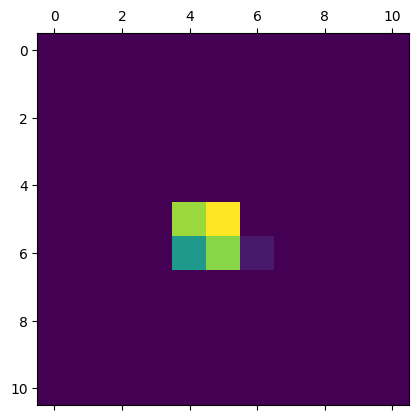

In [ ]:
plt.matshow(patches[1105])
plt.show()

In [ ]:
import h5py
import numpy as np

# Assume these already exist:
# patches: shape (N, 11, 11)
# labels:  shape (N,)          -> e.g., 0 for photon, 1 for splitOff
# showerE: shape (N,)
# thrownE: shape (N,)

output_path = "FCAL_patches_dataset.h5"

with h5py.File(output_path, "w") as f:
    # Create datasets
    f.create_dataset("patches", data=patches, compression="gzip", compression_opts=9)
    f.create_dataset("label", data=df["labels"].astype(np.int8))
    f.create_dataset("showerE", data=df["showerE"].astype(np.float32))
    f.create_dataset("thrownE", data=df["thrownEnergy"].astype(np.float32))

    # Add some metadata
    f.attrs["description"] = "GlueX FCAL 11x11 patches centered on max-energy cell"
    f.attrs["label_mapping"] = "{0: splitOff, 1: photon}"
    f.attrs["patch_shape"] = patches.shape[1:]

print(f"✅ Saved dataset with {len(patches)} entries to {output_path}")


✅ Saved dataset with 814151 entries to FCAL_patches_dataset.h5


In [ ]:
from numba import njit
import numpy as np

@njit
def make_patch_numba(rows, cols, energies, patch_size=11):
    m = np.zeros((patch_size, patch_size), dtype=np.float32)
    half = patch_size // 2
    idx_max = np.argmax(energies)
    center_r = rows[idx_max]
    center_c = cols[idx_max]

    for i in range(len(energies)):
        r = rows[i]
        c = cols[i]
        e = energies[i]
        lr = r - center_r + half
        lc = c - center_c + half
        if 0 <= lr < patch_size and 0 <= lc < patch_size:
            m[int(lr), int(lc)] = e
    return m


from joblib import Parallel, delayed

patches = Parallel(n_jobs=8)(
    delayed(make_patch_numba)(evnt.rows, evnt.cols, evnt.energies)
    for evnt in df
)

AttributeError: 'str' object has no attribute 'rows'

## Looking at distributions

In [ ]:
photons = df[df['isNeutralShower'] == True]
charged = df[df['isChargedShower'] == True]
splitOffs = df[df['isSplitOff'] == True]

In [ ]:
df.columns

Index(['thrownPID', 'thrownEnergy', 'thrownMass', 'showerE', 'rows', 'cols',
       'energies', 'isSplitOff', 'isChargedShower', 'isNeutralShower', 'E1E9',
       'E9E25', 'sumU', 'sumV'],
      dtype='object')

In [ ]:
photons_nhits = photons['rows'].apply(len)
charged_nhits = charged['rows'].apply(len)
splitOffs_nhits = splitOffs['rows'].apply(len)

showerE_photons = photons['showerE']
showerE_charged = charged['showerE']
showerE_splitOffs = splitOffs['showerE']

showerE1E9_photons = photons['E1E9']
showerE1E9_charged = charged['E1E9']
showerE1E9_splitOffs = splitOffs['E1E9']

showerE9E25_photons = photons['E9E25']
showerE9E25_charged = charged['E9E25']
showerE9E25_splitOffs = splitOffs['E9E25']

showerU_photons = photons['sumU']
showerU_charged = charged['sumU']
showerU_splitOffs = splitOffs['sumU']

showerV_photons = photons['sumV']
showerV_charged = charged['sumV']
showerV_splitOffs = splitOffs['sumV']


In [ ]:
print(photons["cols"].min(), photons["cols"].max())
print(photons["rows"].min(), photons["rows"].max())

0 58
0 58


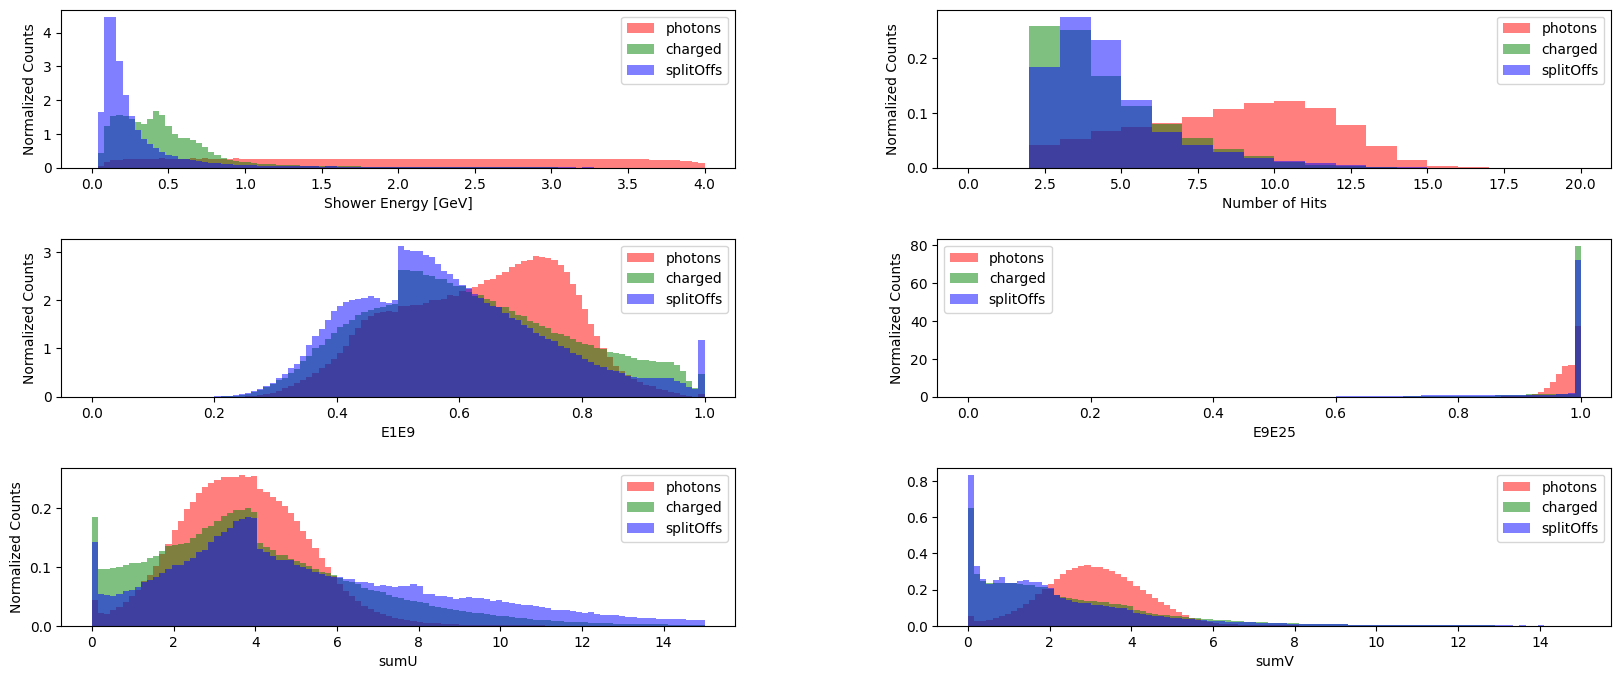

In [ ]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 8), gridspec_kw={"hspace": 0.45, "wspace": 0.30})
ax = axs[0,0]
ax.hist(showerE_photons, bins = 100, range = (0., 4.0), label = "photons", alpha = 0.5, density = True, color = "red")
ax.hist(showerE_charged, bins = 100, range = (0., 4.0), label = "charged", alpha = 0.5, density = True, color = "green")
ax.hist(showerE_splitOffs, bins = 100, range = (0., 4.0), label = "splitOffs", alpha = 0.5, density = True, color = "blue")
ax.set_xlabel("Shower Energy [GeV]")
ax.set_ylabel("Normalized Counts")
ax.legend()

ax = axs[0,1]
ax.hist(photons_nhits, bins = 20, range = (0, 20), label = "photons", alpha = 0.5, density = True, color = "red")
ax.hist(charged_nhits, bins = 20, range = (0, 20), label = "charged", alpha = 0.5, density = True, color = "green")
ax.hist(splitOffs_nhits, bins = 20, range = (0, 20), label = "splitOffs", alpha = 0.5, density = True, color = "blue")
ax.set_xlabel("Number of Hits")
ax.set_ylabel("Normalized Counts")
ax.legend()

ax = axs[1,0]
ax.hist(showerE1E9_photons, bins = 100, range = (0., 1.0), label = "photons", alpha = 0.5, density = True, color = "red")
ax.hist(showerE1E9_charged, bins = 100, range = (0., 1.0), label = "charged", alpha = 0.5, density = True, color = "green")
ax.hist(showerE1E9_splitOffs, bins = 100, range = (0., 1.0), label = "splitOffs", alpha = 0.5, density = True, color = "blue")
ax.set_xlabel("E1E9")
ax.set_ylabel("Normalized Counts")
ax.legend()

ax = axs[1,1]
ax.hist(showerE9E25_photons, bins = 100, range = (0., 1.0), label = "photons", alpha = 0.5, density = True, color = "red")
ax.hist(showerE9E25_charged, bins = 100, range = (0., 1.0), label = "charged", alpha = 0.5, density = True, color = "green")
ax.hist(showerE9E25_splitOffs, bins = 100, range = (0., 1.0), label = "splitOffs", alpha = 0.5, density = True, color = "blue")
ax.set_xlabel("E9E25")
ax.set_ylabel("Normalized Counts")
ax.legend()

ax = axs[2,0]
ax.hist(showerU_photons, bins = 100, range = (0., 15.), label = "photons", alpha = 0.5, density = True, color = "red")
ax.hist(showerU_charged, bins = 100, range = (0., 15.), label = "charged", alpha = 0.5, density = True, color = "green")
ax.hist(showerU_splitOffs, bins = 100, range = (0., 15.), label = "splitOffs", alpha = 0.5, density = True, color = "blue")
ax.set_xlabel("sumU")
ax.set_ylabel("Normalized Counts")
ax.legend()

ax = axs[2,1]
ax.hist(showerV_photons, bins = 100, range = (0., 15.), label = "photons", alpha = 0.5, density = True, color = "red")
ax.hist(showerV_charged, bins = 100, range = (0., 15.), label = "charged", alpha = 0.5, density = True, color = "green")
ax.hist(showerV_splitOffs, bins = 100, range = (0., 15.), label = "splitOffs", alpha = 0.5, density = True, color = "blue")
ax.set_xlabel("sumV")
ax.legend()

plt.show()

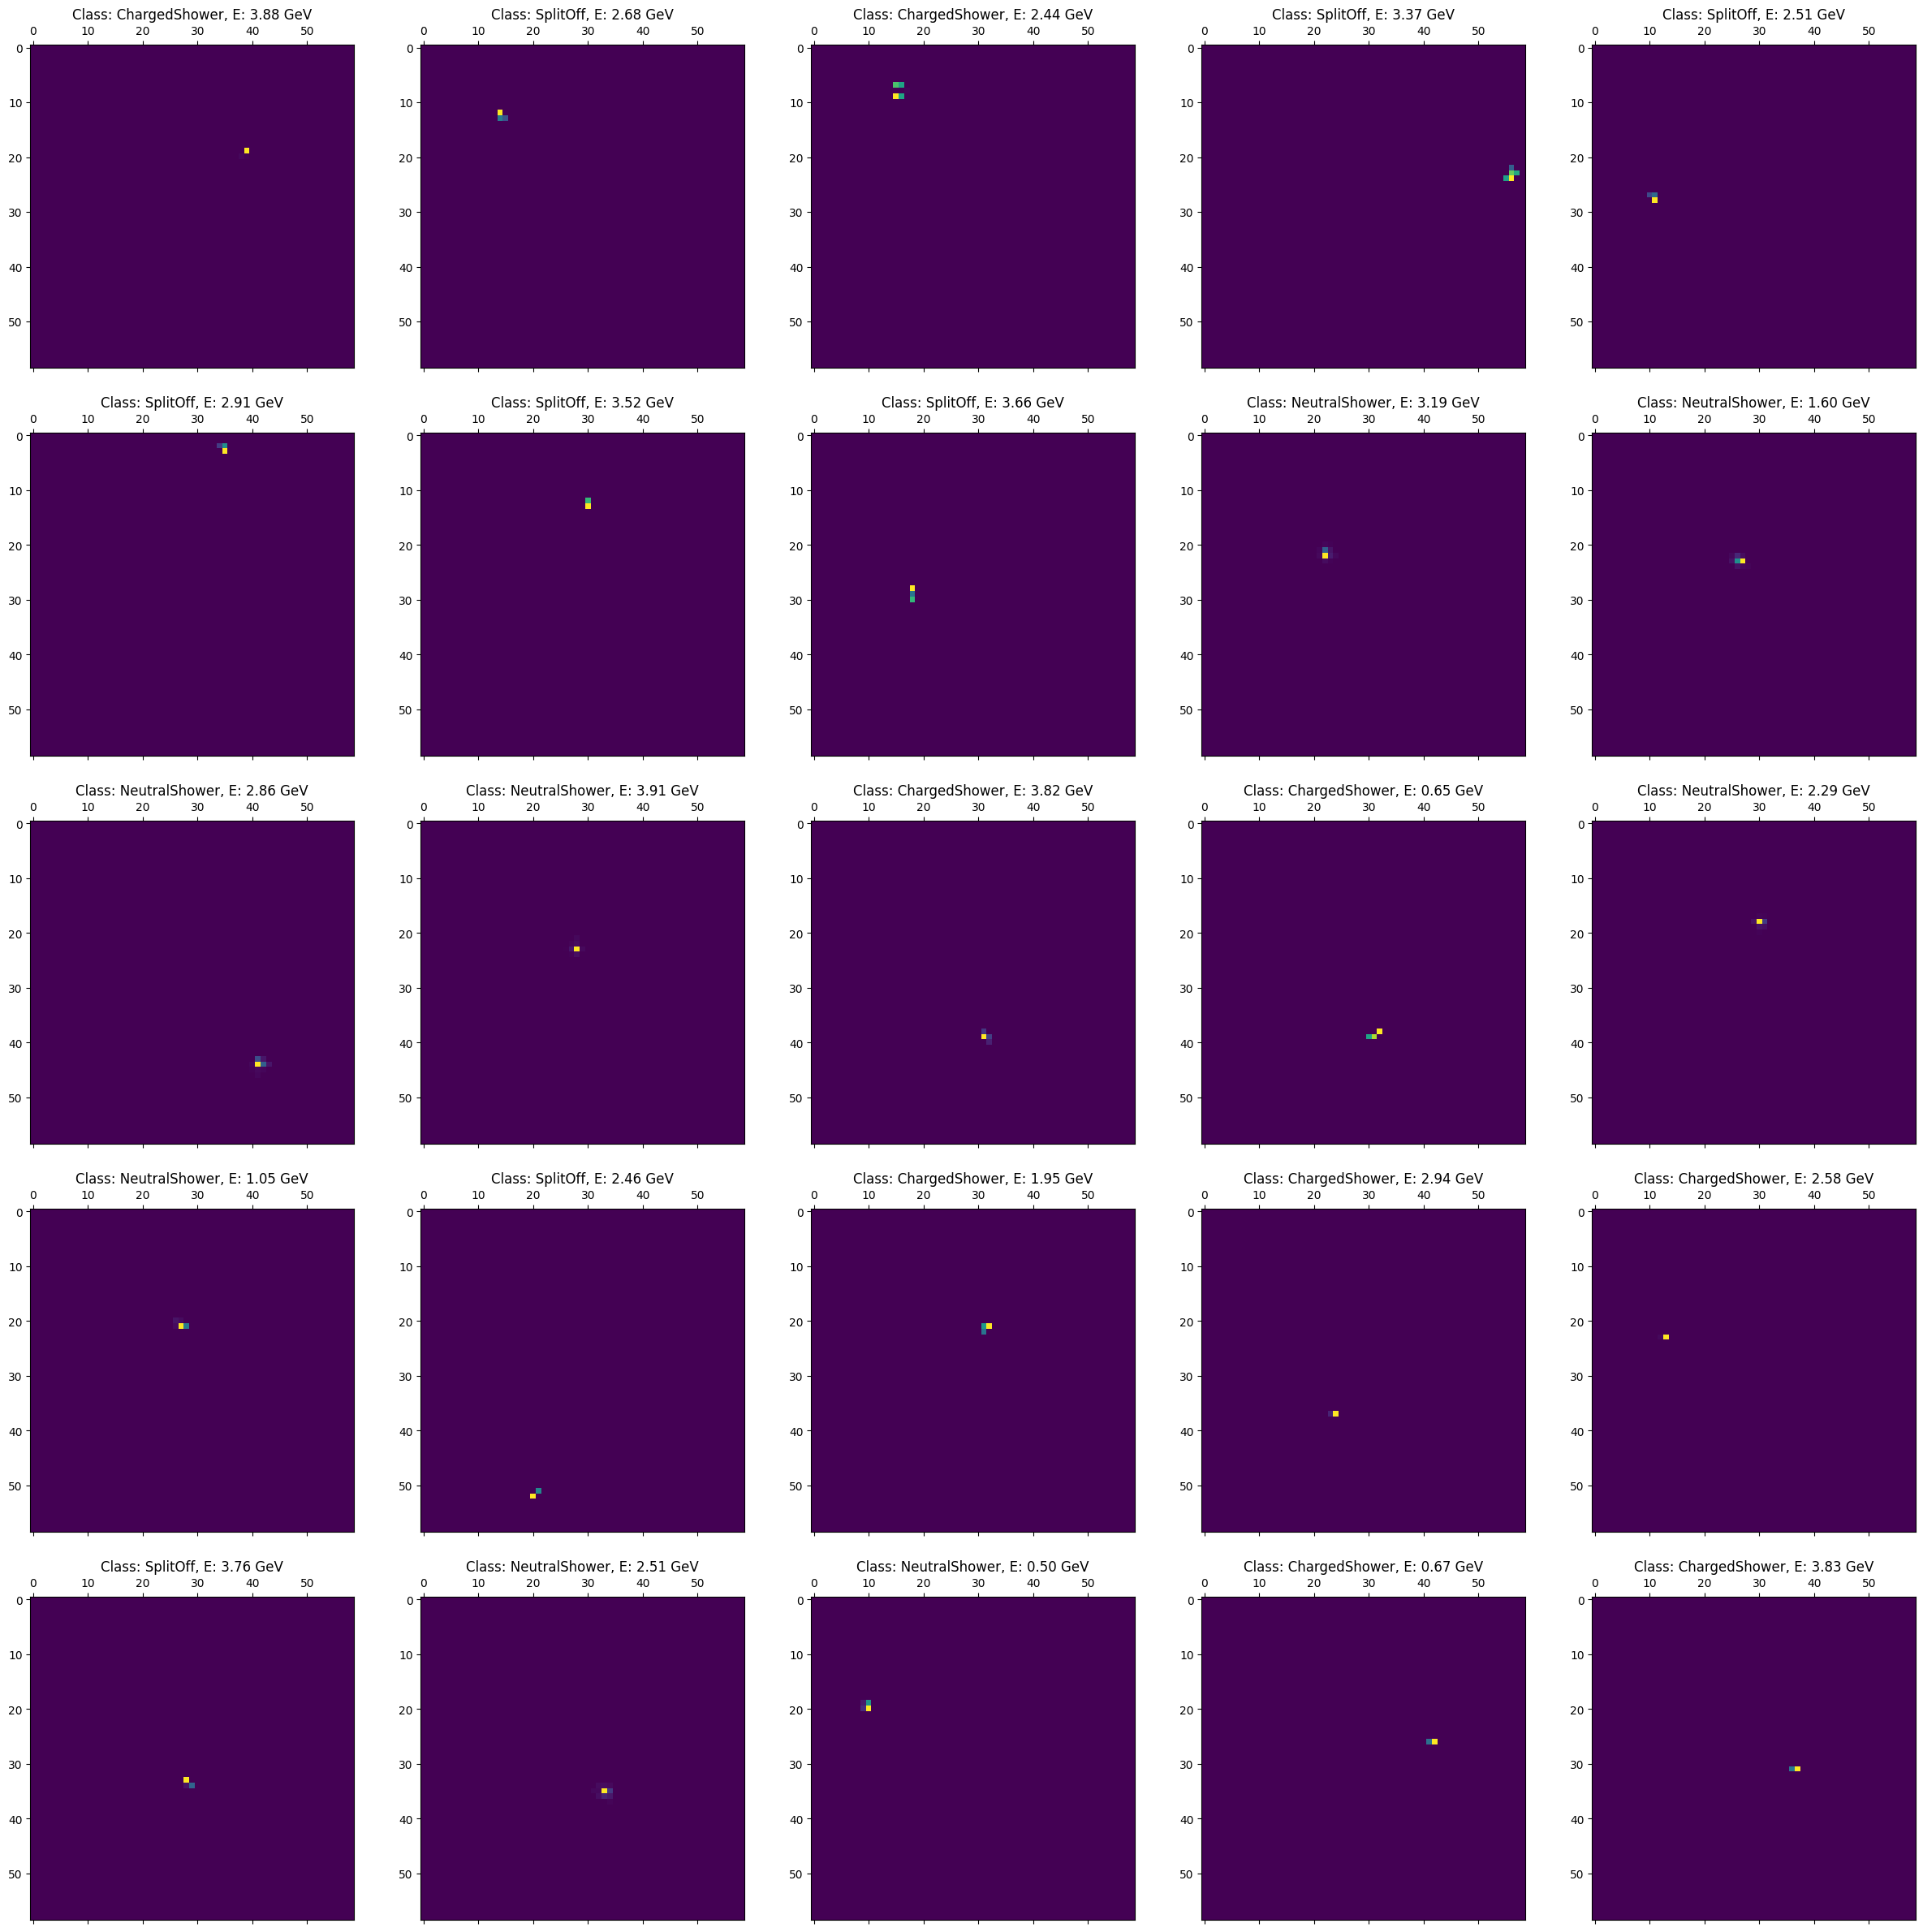

In [ ]:
# Lets make a HitMap of all the hits.

FCAL_GEOMETRY = (59, 59)

def MakeHitMap(evnt, min_hits = 1):
  if len(evnt.rows) < min_hits: return None
  matrix_energies = np.zeros(FCAL_GEOMETRY)
  matrix_energies[evnt.rows, evnt.cols] = evnt.energies
  return matrix_energies

# Lets draw a few images side by side
titles = ["isNeutralShower", "isChargedShower", "isSplitOff"]
NROWS = 5
NCOLS = 5
fig, axs = plt.subplots(nrows = NROWS, ncols = NCOLS, figsize = (30, 30))

for r in range(NROWS):
  for c in range(NCOLS):
    evt = df.iloc[r * NCOLS + c]
    hitmap = MakeHitMap(evt)
    if hitmap is None: continue
    #axs[r, c].matshow(hitmap, cmap='hot', origin = "lower")
    axs[r, c].matshow(hitmap)

    title = ""
    if evt.isNeutralShower:
      title += "NeutralShower"
    elif evt.isChargedShower:
      title += "ChargedShower"
    else:
      title += "SplitOff"
    axs[r, c].set_title(f"Class: {title}, E: {df.iloc[r * NCOLS + c].thrownEnergy:.2f} GeV")
plt.show()


## Distinguishing Split-offs from Photons

In [ ]:
# ================== FAST TRAINER FOR SPLIT-OFF vs PHOTON (fixed dtypes + AMP API) ==================
import os, math, numpy as np, pandas as pd
from tqdm.auto import tqdm, trange
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score, confusion_matrix
from contextlib import nullcontext

# ---------------------------
# Config
# ---------------------------
WINDOW_SIZE   = 11      # 11x11 crop around seed (no rotations/flips)
ONE_BASED     = False   # set True if rows/cols are 1..59
ENERGY_SCALE  = 0.05    # GeV (for global log scaling)
CLIP_MAX      = 2.0     # GeV per cell clamp for scaling
BATCH_SIZE    = 512
EPOCHS        = 15
LR            = 3e-4
VAL_FRAC      = 0.2
TEST_FRAC     = 0.1
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"
USE_AMP       = (DEVICE == "cuda")   # automatic mixed precision only on CUDA

torch.backends.cudnn.benchmark = True
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("medium")

# ---------------------------
# Precompute fixed windows
# ---------------------------
def _dense_from_hits(r, c, e):
    if r.size == 0: return None
    H = int(r.max()) + 1; W = int(c.max()) + 1
    M = np.zeros((H, W), dtype=np.float32)
    np.add.at(M, (r, c), e.astype(np.float32, copy=False))
    return M

def _crop_pad_around_seed(M, size):
    if M is None or not np.isfinite(M).any(): return None
    r0, c0 = np.unravel_index(np.nanargmax(M), M.shape)
    half = size // 2
    r1, r2 = r0 - half, r0 + half + 1
    c1, c2 = c0 - half, c0 + half + 1
    out = np.zeros((size, size), dtype=np.float32)
    r1s, c1s = max(r1,0), max(c1,0)
    r2s, c2s = min(r2,M.shape[0]), min(c2,M.shape[1])
    r1d, c1d = r1s - r1, c1s - c1
    r2d, c2d = r1d + (r2s - r1s), c1d + (c2s - c1s)
    out[r1d:r2d, c1d:c2d] = M[r1s:r2s, c1s:c2s]
    return out

def _log_global_norm(W, e0=ENERGY_SCALE, emax=CLIP_MAX):
    # Keep everything float32 to avoid silent upcasts to float64
    W    = W.clip(min=0).astype(np.float32, copy=False)
    e0   = np.float32(e0)
    emax = np.float32(emax)
    Z = np.log1p(W / e0).astype(np.float32, copy=False)
    Z /= np.log1p(emax / e0).astype(np.float32, copy=False)
    np.clip(Z, 0.0, 1.0, out=Z)
    return Z  # float32

def prepare_windows(df, window=WINDOW_SIZE, one_based=ONE_BASED):
    d = df.copy()
    for col in ("isSplitOff", "isNeutralShower", "isChargedShower"):
        if col in d: d[col] = d[col].fillna(False).astype(bool)

    photons   = d[(d["isNeutralShower"]) & (~d["isSplitOff"]) & (~d.get("isChargedShower", False))]
    splitoffs = d[(d["isSplitOff"])]

    data = pd.concat([photons, splitoffs], ignore_index=True)
    y    = data["isSplitOff"].values.astype(np.int64, copy=False)  # 0=photon, 1=splitoff

    X_list = []
    bar = tqdm(range(len(data)), desc="Precomputing windows", leave=True)
    for i in bar:
        row = data.iloc[i]
        r = np.asarray(row["rows"], dtype=np.int32)
        c = np.asarray(row["cols"], dtype=np.int32)
        e = np.asarray(row["energies"], dtype=np.float32)
        if one_based:
            r -= 1; c -= 1
        M = _dense_from_hits(r, c, e)
        crop = _crop_pad_around_seed(M, window)
        if crop is None:
            crop = np.zeros((window, window), dtype=np.float32)
        X_list.append(_log_global_norm(crop))

    X = np.stack(X_list, axis=0).astype(np.float32, copy=False)  # (N, H, W), float32
    X = X[:, None, :, :]                                         # (N, 1, H, W)
    return X, y

# ---------------------------
# Model
# ---------------------------
class SmallCNN(nn.Module):
    def __init__(self, in_ch=1, n_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.head = nn.Linear(64, n_classes)
    def forward(self, x):
        return self.head(self.net(x).flatten(1))

# ---------------------------
# Dataloaders
# ---------------------------
def make_single_loader_from_arrays(X, y, batch_size = BATCH_SIZE, num_workers = 0):
  n = len(y)
  idx = np.random.permutation(n)

  Xtr = torch.from_numpy(X[idx]).to(torch.float32)
  ytr = torch.from_numpy(y[idx]).to(torch.int64)

  train_ds = TensorDataset(Xtr, ytr)

  nw = max(2, min(8, (os.cpu_count() or 4) - 1))
  pin = (DEVICE == "cuda")

  train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                            num_workers=nw, pin_memory=pin, persistent_workers=True)
  return train_loader

def make_loaders_from_arrays(X, y, batch_size=BATCH_SIZE, num_workers=0):
    n = len(y)
    idx = np.random.permutation(n)
    n_test  = int(TEST_FRAC * n)
    n_val   = int(VAL_FRAC  * n)
    n_train = n - n_val - n_test
    i_train, i_val, i_test = idx[:n_train], idx[n_train:n_train+n_val], idx[n_train+n_val:]

    # Ensure tensors are float32 / int64
    Xtr = torch.from_numpy(X[i_train]).to(torch.float32)
    Xva = torch.from_numpy(X[i_val]).to(torch.float32)
    Xte = torch.from_numpy(X[i_test]).to(torch.float32)
    ytr = torch.from_numpy(y[i_train]).to(torch.int64)
    yva = torch.from_numpy(y[i_val]).to(torch.int64)
    yte = torch.from_numpy(y[i_test]).to(torch.int64)

    train_ds = TensorDataset(Xtr, ytr)
    val_ds   = TensorDataset(Xva, yva)
    test_ds  = TensorDataset(Xte, yte)

    nw = max(2, min(8, (os.cpu_count() or 4) - 1))
    pin = (DEVICE == "cuda")

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=nw, pin_memory=pin, persistent_workers=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                              num_workers=nw, pin_memory=pin, persistent_workers=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                              num_workers=nw, pin_memory=pin, persistent_workers=True)
    return train_loader, val_loader, test_loader

# ---------------------------
# Eval & Train (with progress bars + new AMP)
# ---------------------------
@torch.inference_mode()
def evaluate(model, loader, desc="Eval"):
    model.eval()
    ys, ps = [], []
    correct = total = 0
    bar = tqdm(loader, desc=desc, leave=False)
    for Xb, yb in bar:
        Xb = Xb.to(DEVICE, non_blocking=True, dtype=torch.float32)
        yb = yb.to(DEVICE, non_blocking=True)
        logits = model(Xb)
        prob = torch.softmax(logits, dim=1)[:, 1]
        pred = logits.argmax(dim=1)
        ys.append(yb.cpu().numpy()); ps.append(prob.cpu().numpy())
        correct += (pred == yb).sum().item(); total += yb.numel()
        bar.set_postfix(acc=f"{(correct/max(1,total)):.3f}")
    y_true = np.concatenate(ys) if ys else np.array([])
    y_prob = np.concatenate(ps) if ps else np.array([])
    acc = correct / max(1, total)
    auc = roc_auc_score(y_true, y_prob) if y_true.size and np.unique(y_true).size > 1 else float("nan")
    return acc, auc, y_true, y_prob

def train_fast(df):
    # 1) Precompute windows
    X, y = prepare_windows(df, WINDOW_SIZE, ONE_BASED)
    print(f"Prepared windows: {X.shape}, photons={np.sum(y==0)}, splitoffs={np.sum(y==1)}")

    # 2) Dataloaders
    train_loader, val_loader, test_loader = make_loaders_from_arrays(X, y, BATCH_SIZE)

    # 3) Model, optimizer, class-weighted loss
    model = SmallCNN().to(DEVICE).to(torch.float32)
    opt   = torch.optim.AdamW(model.parameters(), lr=LR)

    counts = np.bincount(y, minlength=2).astype(np.float32)
    weights = torch.tensor((counts.sum() / (counts + 1e-6)), dtype=torch.float32, device=DEVICE)
    crit  = nn.CrossEntropyLoss(weight=weights)

    scaler = torch.amp.GradScaler('cuda') if USE_AMP else None

    # 4) Train
    best_auc, best_state, patience, bad = -1.0, None, 5, 0
    for epoch in trange(1, EPOCHS+1, desc="Training"):
        model.train()
        running, seen, correct = 0.0, 0, 0
        bar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} (train)", leave=False)

        for Xb, yb in bar:
            Xb = Xb.to(DEVICE, non_blocking=True, dtype=torch.float32)
            yb = yb.to(DEVICE, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            ctx = torch.amp.autocast(device_type='cuda', dtype=torch.float16) if USE_AMP else nullcontext()
            with ctx:
                logits = model(Xb)
                loss = crit(logits, yb)

            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                loss.backward()
                opt.step()

            running += loss.item() * yb.size(0)
            seen    += yb.size(0)
            correct += (logits.argmax(1) == yb).sum().item()
            bar.set_postfix(avg_loss=f"{running/max(1,seen):.4f}", acc=f"{(correct/max(1,seen)):.3f}")

        train_loss = running / max(1, seen)
        val_acc, val_auc, _, _ = evaluate(model, val_loader, desc=f"Epoch {epoch}/{EPOCHS} (val)")
        tqdm.write(f"Epoch {epoch:02d} | train_loss {train_loss:.4f} | val_acc {val_acc:.4f} | val_auc {val_auc:.4f}")

        score = 0.0 if math.isnan(val_auc) else val_auc
        if score > best_auc:
            best_auc, bad = score, 0
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            tqdm.write(f"✓ New best AUC {best_auc:.4f}")
        else:
            bad += 1
            if bad >= patience:
                tqdm.write("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # 5) Test
    test_acc, test_auc, y_true, y_prob = evaluate(model, test_loader, desc="Test")
    cm = confusion_matrix(y_true, (y_prob >= 0.5).astype(int), labels=[0,1])
    print(f"Test | acc {test_acc:.4f} | auc {test_auc:.4f}")
    print("Confusion matrix [rows=true, cols=pred] (0=photon,1=splitoff):\n", cm)
    return model, y_true, y_prob

# ---- run it ----
# model = train_fast(df)


In [ ]:
model, y_true, y_prob = train_fast(df)

Precomputing windows:   0%|          | 0/814151 [00:00<?, ?it/s]

Prepared windows: (814151, 1, 11, 11), photons=434845, splitoffs=379306


Training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 1/15 (val):   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 01 | train_loss 0.2722 | val_acc 0.8965 | val_auc 0.9583
✓ New best AUC 0.9583


Epoch 2/15 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 2/15 (val):   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 02 | train_loss 0.2580 | val_acc 0.8999 | val_auc 0.9597
✓ New best AUC 0.9597


Epoch 3/15 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 3/15 (val):   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 03 | train_loss 0.2547 | val_acc 0.9000 | val_auc 0.9602
✓ New best AUC 0.9602


Epoch 4/15 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 4/15 (val):   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 04 | train_loss 0.2530 | val_acc 0.9005 | val_auc 0.9605
✓ New best AUC 0.9605


Epoch 5/15 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 5/15 (val):   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 05 | train_loss 0.2517 | val_acc 0.9015 | val_auc 0.9608
✓ New best AUC 0.9608


Epoch 6/15 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 6/15 (val):   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 06 | train_loss 0.2507 | val_acc 0.9017 | val_auc 0.9612
✓ New best AUC 0.9612


Epoch 7/15 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 7/15 (val):   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 07 | train_loss 0.2499 | val_acc 0.9018 | val_auc 0.9611


Epoch 8/15 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 8/15 (val):   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 08 | train_loss 0.2492 | val_acc 0.9011 | val_auc 0.9616
✓ New best AUC 0.9616


Epoch 9/15 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 9/15 (val):   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 09 | train_loss 0.2486 | val_acc 0.9027 | val_auc 0.9615


Epoch 10/15 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 10/15 (val):   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 10 | train_loss 0.2479 | val_acc 0.9021 | val_auc 0.9618
✓ New best AUC 0.9618


Epoch 11/15 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 11/15 (val):   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 11 | train_loss 0.2474 | val_acc 0.9030 | val_auc 0.9618
✓ New best AUC 0.9618


Epoch 12/15 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 12/15 (val):   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 12 | train_loss 0.2467 | val_acc 0.9026 | val_auc 0.9619
✓ New best AUC 0.9619


Epoch 13/15 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 13/15 (val):   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 13 | train_loss 0.2466 | val_acc 0.9022 | val_auc 0.9622
✓ New best AUC 0.9622


Epoch 14/15 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 14/15 (val):   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 14 | train_loss 0.2460 | val_acc 0.9024 | val_auc 0.9620


Epoch 15/15 (train):   0%|          | 0/1114 [00:00<?, ?it/s]

Epoch 15/15 (val):   0%|          | 0/319 [00:00<?, ?it/s]

Epoch 15 | train_loss 0.2454 | val_acc 0.9032 | val_auc 0.9621


Test:   0%|          | 0/160 [00:00<?, ?it/s]

Test | acc 0.9022 | auc 0.9620
Confusion matrix [rows=true, cols=pred] (0=photon,1=splitoff):
 [[38435  4987]
 [ 2979 35014]]


In [ ]:
model

SmallCNN(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): AdaptiveAvgPool2d(output_size=1)
  )
  (head): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
# Reference values from https://arxiv.org/pdf/2002.09530
# 85% signal with 60% background rejection


import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix

# y_true: 0 = photon (signal), 1 = split-off (background)
# y_prob: model score = P(split-off)

def eff_rej_at_threshold(y_true, y_prob, thr):
    y_true = np.asarray(y_true, dtype=int)
    y_prob = np.asarray(y_prob, dtype=float)

    keep_photon = (y_prob < thr)
    Nsig = np.sum(y_true == 0); Nbkg = np.sum(y_true == 1)

    eps_sig = np.sum((y_true == 0) & keep_photon) / max(1, Nsig)
    rej_bkg = np.sum((y_true == 1) & (~keep_photon)) / max(1, Nbkg)  # predicted split-off

    # Predicted label: 1=split-off, 0=photon (consistent with y_true)
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    return eps_sig, rej_bkg, cm

def eff_rej_curve(y_true, y_prob):
    # Standard ROC for positive class = split-off (1)
    fpr, tpr, thrs = roc_curve(y_true, y_prob, pos_label=1)
    # Map to your physics metrics:
    eps_sig = 1.0 - fpr   # photon efficiency
    rej_bkg = tpr         # split-off rejection
    return eps_sig, rej_bkg, thrs

# --- Example usage ---
# If you have them already from evaluate():
# y_true, y_prob = <from your test set>

# 1) Curve over all thresholds
eps_sig, rej_bkg, thrs = eff_rej_curve(y_true, y_prob)

# 2) Pick a working point: match Barsotti–Shepherd ε_sig ≈ 0.85
target_eps = 0.85
i = int(np.argmin(np.abs(eps_sig - target_eps)))
thr_star = thrs[i]
eps_star, rej_star, cm_star = eff_rej_at_threshold(y_true, y_prob, thr_star)

print(f"Working point (ε_sig≈{target_eps:.2f}):")
print(f"  threshold = {thr_star:.4f}")
print(f"  ε_sig (photon eff)   = {eps_star:.4f}")
print(f"  R_bkg (split-off rej)= {rej_star:.4f}")
print("  Confusion matrix [rows=true, cols=pred] (0=photon,1=splitoff):")
print(cm_star)

# 3) If you just want your current threshold, e.g. t=0.5:
eps_05, rej_05, cm_05 = eff_rej_at_threshold(y_true, y_prob, 0.5)
print(f"\nAt t=0.50: ε_sig={eps_05:.4f}, R_bkg={rej_05:.4f}")


Working point (ε_sig≈0.85):
  threshold = 0.3529
  ε_sig (photon eff)   = 0.8499
  R_bkg (split-off rej)= 0.9426
  Confusion matrix [rows=true, cols=pred] (0=photon,1=splitoff):
[[36906  6516]
 [ 2182 35811]]

At t=0.50: ε_sig=0.8852, R_bkg=0.9216


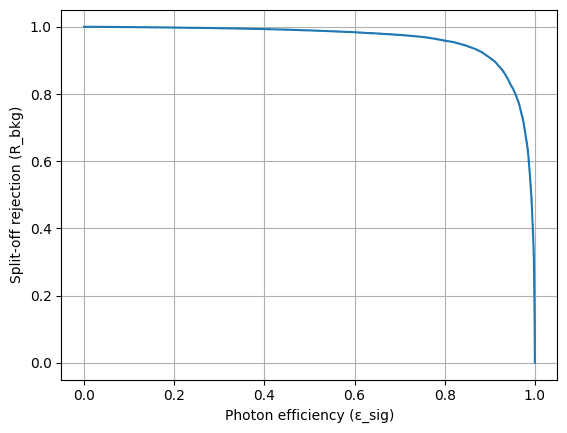

In [ ]:
plt.plot(eps_sig, rej_bkg)
plt.xlabel("Photon efficiency (ε_sig)")
plt.ylabel("Split-off rejection (R_bkg)")
plt.grid(True); plt.show()

In [ ]:
# Lets try with Omega

import uproot, pandas as pd, awkward as ak, vector
import numpy as np, matplotlib.pyplot as plt
vector.register_awkward()


omega_path = "/content/drive/MyDrive/DNP-2025/OmegaExclusive/OmegaExclusive.root"
omega_tree = uproot.open(omega_path)["OmegaSampleTree"]

In [ ]:
for branch in omega_tree.branches:
    print (f"{branch.name} of type {branch.typename}")

thrownPiPlus of type TLorentzVector
thrownPiMinus of type TLorentzVector
thrownRecoilProton of type TLorentzVector
thrownPi0 of type TLorentzVector
reconPiPlus of type TLorentzVector
reconPiMinus of type TLorentzVector
reconRecoilProton of type TLorentzVector
thrownBeam of type TLorentzVector
thrownOmegaMass of type double
rows of type std::vector<int32_t>
cols of type std::vector<int32_t>
energies of type std::vector<double>
times of type std::vector<double>
nShowers of type int32_t
showerT of type std::vector<double>
numBlocks of type std::vector<int32_t>
showerE of type std::vector<double>
sumU of type std::vector<double>
sumV of type std::vector<double>
E9E25 of type std::vector<double>
E1E9 of type std::vector<double>
nHitsPerShower of type std::vector<int32_t>
startIndexPerShower of type std::vector<int32_t>
FCALNeutralShowerPx of type std::vector<double>
FCALNeutralShowerPy of type std::vector<double>
FCALNeutralShowerPz of type std::vector<double>
FCALNeutralShowerE of type std

In [ ]:
# Lets convert the tree into array
tree_ak = omega_tree.arrays(library="ak")

In [ ]:
len(tree_ak)

24814

In [ ]:
# lets go through events and makeShowerHitMaps

def MakeShowerHitMaps(event, FCAL_GEOM = (59, 59)) -> dict:
  nShowers = event.nShowers
  matrix_energies = np.zeros((nShowers, *FCAL_GEOM))
  FourVectors = []
  for i in range(nShowers):
    start_idx = event.startIndexPerShower[i]
    end_idx = start_idx + event.nHitsPerShower[i]
    matrix_energies[i, event.rows[start_idx:end_idx], event.cols[start_idx:end_idx]] = event.energies [start_idx:end_idx]
    # lets make a radius and center of shower to draw it.
    lorentzVector = vector.obj(
        px = event.FCALNeutralShowerPx[i],
        py = event.FCALNeutralShowerPy[i],
        pz = event.FCALNeutralShowerPz[i],
        E = event.FCALNeutralShowerE[i],
    )
    FourVectors.append(lorentzVector)
  return {"hitmap" : matrix_energies, "4vector" :  FourVectors}

In [ ]:
# lets get into a inference pipeline

def make4Vector(field):
  return vector.obj(
      px = field.fP.fX,
      py = field.fP.fY,
      pz = field.fP.fZ,
      E = field.fE
  )

def runInference(hitMap, energy):
  "do inference using CNN, an example of returning True 50% of time. Here energy is simply used as a hard cut"
  return False if energy < 0.5 else True

reco_pi0Mass = []
reco_omegaMass = []
_device = "cpu"
model.to(_device)
model.eval()
for evt in tree_ak:
  HitMapDict = MakeShowerHitMaps(evt)
  goodShowers = []
  for hitMap, fourVector in zip(HitMapDict["hitmap"], HitMapDict["4vector"]):
    logits = model(torch.from_numpy(hitMap).to(torch.float32))
    pred = logits.argmax(dim=1)
    if pred == 1:
      goodShowers.append(fourVector)
  piplus = make4Vector(evt.thrownPiPlus)
  piminus = make4Vector(evt.thrownPiMinus)
  pi0 = goodShowers[0] + goodShowers[1]
  reco_pi0Mass.append(pi0.mass)
  reco_omegaMass.append((pi0 + piplus + piminus).mass)

ValueError: expected 4D input (got 3D input)

In [ ]:
# lets plot in bins of momentum to see how the model performs

momentum_bins = [0.250, 0.500, 0.750, 1.0, 1.5, 2.0, 3.0, 4.0]



## Regression

### Apply the classifier -- build dataset of predicted photons

In [ ]:
# Choose which rows to score (recommended: neutral candidates only)
to_score = df[(df.get("isChargedShower", False) == False) & (df.get("thrownEnergy") < 1.0)]  # or add "& (df['isNeutralShower']==True)"

def build_windows_for(df_subset):
    X_list = []
    for _, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc="Windows for scoring"):
        r = np.asarray(row["rows"], dtype=np.int32)
        c = np.asarray(row["cols"], dtype=np.int32)
        e = np.asarray(row["energies"], dtype=np.float32)
        if ONE_BASED:
            r -= 1; c -= 1
        M = _dense_from_hits(r, c, e)
        crop = _crop_pad_around_seed(M, WINDOW_SIZE)
        if crop is None: crop = np.zeros((WINDOW_SIZE, WINDOW_SIZE), dtype=np.float32)
        X_list.append(_log_global_norm(crop))
    X = np.stack(X_list, axis=0).astype(np.float32)[:, None, :, :]
    return X

X_all = build_windows_for(to_score)

def predict_splitoff_prob(model, X, batch_size=1024):
    model.eval()
    ds = TensorDataset(torch.from_numpy(X).to(torch.float32))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=0)
    probs = []
    with torch.no_grad():
        for (xb,) in tqdm(loader, desc="Scoring"):
            xb = xb.to(DEVICE, dtype=torch.float32)
            logits = model(xb)
            p = torch.softmax(logits, dim=1)[:, 1]  # P(split-off)
            probs.append(p.cpu().numpy())
    return np.concatenate(probs)

# Pick a threshold:
# - t=0.5 (default), or
# - the threshold that gave ε_sig≈0.85 when you matched Barsotti–Shepherd
t = 0.5

p_split = predict_splitoff_prob(model.to(DEVICE), X_all)
pred_is_photon = p_split < t

# ----- DATASET 1: predicted photons -----
dataset1 = to_score.loc[pred_is_photon].copy()
dataset1["p_splitoff"] = p_split[pred_is_photon]

Windows for scoring:   0%|          | 0/123760 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9c39d29300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1628, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
    

Scoring:   0%|          | 0/121 [00:00<?, ?it/s]

In [ ]:
ds = TensorDataset(torch.from_numpy(X_all).to(torch.float32))
loader = DataLoader(ds, batch_size=1024, shuffle=False, num_workers=0)
atest_acc, atest_auc, ay_true, ay_prob = evaluate(model, loader, desc="Test")
acm = confusion_matrix(ay_true, (ay_prob >= 0.5).astype(int), labels=[0,1])
print(f"Test | acc {atest_acc:.4f} | auc {atest_auc:.4f}")
print("Confusion matrix [rows=true, cols=pred] (0=photon,1=splitoff):\n", acm)

Test:   0%|          | 0/121 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 2, got 1)

### Truth-matched photons and purity

In [ ]:
# dataset2: predicted ∧ truth photons (intersection)
dataset2 = dataset1[dataset1["thrownPID"] == 22].copy()

# --------- Efficiencies (two denominators) ---------
truth_all_mask    = (df["thrownPID"] == 22)
truth_scored_mask = to_score["thrownPID"] == 22

N_truth_all    = int(truth_all_mask.sum())
N_truth_scored = int(truth_scored_mask.sum())

# efficiency relative to ALL truth photons in df  (what you printed before)
eff_global  = len(dataset2) / max(1, N_truth_all)

# efficiency relative to TRUTH PHOTONS INSIDE THE SCORED SET (ROC-consistent)
eff_scored  = len(dataset2) / max(1, N_truth_scored)

print(f"Truth photons in df:         {N_truth_all}")
print(f"Truth photons that were scored: {N_truth_scored}")
print(f"Signal efficiency (global)  = {eff_global:.4f}")
print(f"Signal efficiency (scored)  = {eff_scored:.4f}  <-- compare this to ROC")

Truth photons in df:         512141
Truth photons that were scored: 512141
Signal efficiency (global)  = 0.8130
Signal efficiency (scored)  = 0.8130  <-- compare this to ROC


### Train Regressor on all Truth Photons

In [ ]:
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Build windows/targets for all truth photons
truth_photons = df[df["isNeutralShower"] == True]
X_reg = build_windows_for(truth_photons)
y_reg = truth_photons["thrownEnergy"].to_numpy(dtype=np.float32)  # GeV

# Train/val split (stratify by energy bins for stability)
bins = np.clip((y_reg / 0.25).astype(int), 0, None)  # ~250 MeV bins
i_tr, i_va = train_test_split(np.arange(len(y_reg)), test_size=0.2, random_state=42, stratify=bins)

tr_ds = TensorDataset(torch.from_numpy(X_reg[i_tr]).to(torch.float32),
                      torch.from_numpy(y_reg[i_tr]).to(torch.float32))
va_ds = TensorDataset(torch.from_numpy(X_reg[i_va]).to(torch.float32),
                      torch.from_numpy(y_reg[i_va]).to(torch.float32))

tr_loader = DataLoader(tr_ds, batch_size=512, shuffle=True,  num_workers=0)
va_loader = DataLoader(va_ds, batch_size=1024, shuffle=False, num_workers=0)

# Small CNN regressor
class SmallCNNReg(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.head = nn.Linear(64, 1)  # predict energy in GeV

    def forward(self, x):
        x = self.body(x).flatten(1)
        return self.head(x).squeeze(1)

reg = SmallCNNReg().to(DEVICE)
opt = torch.optim.AdamW(reg.parameters(), lr=3e-4)
loss_fn = nn.SmoothL1Loss(beta=0.05)  # Huber; robust to tails

from tqdm.auto import trange
best_va, best = 1e9, None
for ep in trange(1, 31, desc="Regressor training"):
    reg.train()
    for xb, yb in tr_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        pred = reg(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad(set_to_none=True); loss.backward(); opt.step()

    reg.eval()
    with torch.no_grad():
        va_err = []
        for xb, yb in va_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            pred = reg(xb)
            va_err.append(nn.functional.l1_loss(pred, yb).item())  # MAE
        mae = float(np.mean(va_err))
    if mae < best_va:
        best_va, best = mae, {k: v.detach().cpu().clone() for k, v in reg.state_dict().items()}
        tqdm.write(f"  ✓ new best MAE {best_va:.3f} GeV")

if best is not None:
    reg.load_state_dict(best)


Windows for scoring:   0%|          | 0/434845 [00:00<?, ?it/s]

Regressor training:   0%|          | 0/30 [00:00<?, ?it/s]

  ✓ new best MAE 0.152 GeV
  ✓ new best MAE 0.148 GeV
  ✓ new best MAE 0.145 GeV
  ✓ new best MAE 0.145 GeV
  ✓ new best MAE 0.141 GeV
  ✓ new best MAE 0.141 GeV
  ✓ new best MAE 0.140 GeV
  ✓ new best MAE 0.139 GeV
  ✓ new best MAE 0.138 GeV
  ✓ new best MAE 0.137 GeV
  ✓ new best MAE 0.137 GeV
  ✓ new best MAE 0.137 GeV


### Deploy Regressor on Dataset 1 (showers classified as photons) and Dataset 2 (true photons) and Plot Reconstructed Energy

Regressing:   0%|          | 0/43 [00:00<?, ?it/s]

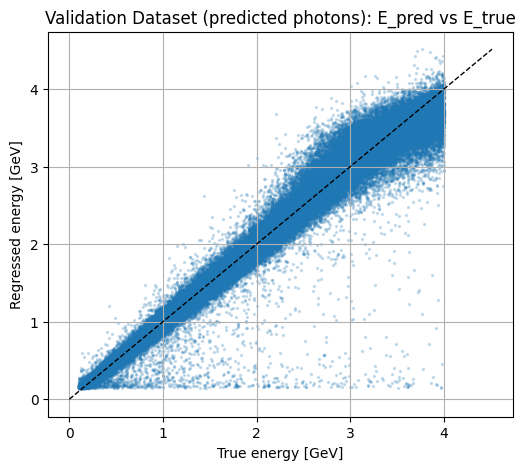

In [ ]:
import matplotlib.pyplot as plt

def regress_on_df(model, ds):
    #X = build_windows_for(df_subset)
    #ds = TensorDataset(torch.from_numpy(X).to(torch.float32))
    loader = DataLoader(ds, batch_size=2048, shuffle=False, num_workers=0)
    preds = []
    E_true = []
    model.eval()
    with torch.no_grad():
        for (xb, yb) in tqdm(loader, desc="Regressing"):
            xb = xb.to(DEVICE)
            preds.append(model(xb).cpu().numpy())
            E_true.append(yb.cpu().numpy())
    E_pred = np.concatenate(preds)
    E_true = np.concatenate(E_true)
    return E_pred, E_true

# Apply to dataset 1 (predicted photons)
Epred_1, Etrue_1 = regress_on_df(reg, va_ds)

# Apply to dataset 2 (truth photons)
#Epred_2, Etrue_2 = regress_on_df(reg, dataset2)

# --- Plots: predicted vs true ---
def scatter_pred_true(E_pred, E_true, title):
    if E_true is None:
        print(f"{title}: no thrownEnergy available.")
        return
    plt.figure(figsize=(6,5))
    plt.scatter(E_true, E_pred, s=2, alpha=0.2)
    lim = (0, max(1e-6, float(np.nanmax([E_true.max(), E_pred.max()]))))
    plt.plot(lim, lim, 'k--', lw=1)
    plt.xlabel("True energy [GeV]")
    plt.ylabel("Regressed energy [GeV]")
    plt.title(title)
    plt.grid(True)
    plt.show()

scatter_pred_true(Epred_1, Etrue_1, "Validation Dataset (predicted photons): E_pred vs E_true")
#scatter_pred_true(Epred_2, Etrue_2, "Dataset 2 (truth photons): E_pred vs E_true")
